In [2]:
from spectrae import Spectra, SpectraDataset
from torchdrug import datasets
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm


# SPECTRA Sequence Tutorial

### We take an example dataset from PEER, the YeastPPI dataset, taking the first 50 samples.
### We define a continuous spectral property based on a sequence alignment. When comparing two samples, we perform a pairwise alignment between all proteins in each sample, and take the mean sequence similarity. 
### We define cross-split overlap as the average mean sequence similarity (as described for the spectral property) between all test and train samples.

In [2]:
class PEER_Dataset(SpectraDataset):
    
    def parse(self, input_file):
        if input_file == 'YeastPPI':
            return datasets.YeastPPI("~/protein-datasets/", atom_feature=None, bond_feature=None, residue_feature="default")

    def __len__(self):
        #Using a truncated form of the dataset for sake of demonstration 
        return 50

    def convert_graph_sequence(self, graph):
        res = graph.residue_feature.argmax(axis=1)
        id2residue = {v: k for k, v in graph.residue2id.items()}
        sequence = ''.join([id2residue[res_id.item()] for res_id in res])
        return sequence
    
    def sample_to_index(self, sample):
        if not hasattr(self, 'index_to_sequence'):
            print("Generating index to sequence")
            self.index_to_sequence = {}
            for i in tqdm(range(len(self))):
                x = self.__getitem__(i)
                self.index_to_sequence[f'{x[0]}-{x[1]}'] = i

        return self.index_to_sequence[sample]            

    def __getitem__(self, idx):
        data = self.samples[idx]
        return [self.convert_graph_sequence(data['graph1']),self.convert_graph_sequence(data['graph2']) ]

In [3]:
from Bio import Align

class SPECTRA_sequence(Spectra):

    def spectra_properties(self, sample_one, sample_two):

        aligner = Align.PairwiseAligner()

        aligner.match_score = 1.0
        aligner.mismatch_score = -2.0
        aligner.gap_score = -2.5

        def sequence_similarity(seq1, seq2):

            input = aligner.align(seq1, seq2)[0]
            align_data = str(input).split('\n')
            i, j = align_data[0], align_data[2]

            count = 0
            diff = 0

            for orig, n in zip(i, j):
                if orig != n:
                    diff += 1
                count += 1

            return 1 - diff/count

        similarities = []
        for i in sample_one:
            for j in sample_two:
                similarities.append(sequence_similarity(i, j))

        return np.mean(similarities)

    def cross_split_overlap(self, train, test):
        average_similarity = []

        for i in test:
            for j in train:
                num_i = self.dataset.sample_to_index(f'{i[0]}-{i[1]}')
                num_j = self.dataset.sample_to_index(f'{j[0]}-{j[1]}')
                average_similarity.append(self.spectra_properties(num_i, num_j))

        return np.mean(average_similarity)

In [4]:
PG_Dataset = PEER_Dataset('YeastPPI', 'YeastPPI')

15:35:48   Extracting /Users/yashaektefaie/protein-datasets/yeast_ppi.zip to /Users/yashaektefaie/protein-datasets


Constructing proteins from sequences: 100%|██████████| 38154/38154 [04:11<00:00, 152.00it/s]


In [5]:
pg_spectra = SPECTRA_sequence(PG_Dataset, binary = False)

In [6]:
pg_spectra.pre_calculate_spectra_properties('YEASTPPI_50')

File YEASTPPI_50_precalculated_spectra_properties already exists, set force_recalculate to True to recalculate


In [7]:
spectra_parameters = {'number_repeats': 3, 
                      'random_seed': [42, 44, 46],
                      'spectral_parameters': ["{:.2f}".format(i) for i in np.arange(0, 1.05, 0.05)],
                      'force_reconstruct': True,
                                              }

pg_spectra.generate_spectra_splits(**spectra_parameters)

100%|██████████| 1225/1225 [00:00<00:00, 283258.31it/s]


Stats for SPECTRA property graph (SPG)
Number of nodes: 50
Number of edges: 1225
Number of connected components: 1


Generating SPECTRA split for spectral parameter 0.0 and dataset YeastPPI
Number of samples in independent set: 50
Train size: 40	Test size: 10
Generating index to sequence


100%|██████████| 50/50 [00:00<00:00, 561.01it/s]


Cross split overlap: 0.31203000651611407



Generating SPECTRA split for spectral parameter 0.0 and dataset YeastPPI
Number of samples in independent set: 50
Train size: 40	Test size: 10
Cross split overlap: 0.3198363151824079



Generating SPECTRA split for spectral parameter 0.0 and dataset YeastPPI
Number of samples in independent set: 50
Train size: 40	Test size: 10
Cross split overlap: 0.31663113475988003



Generating SPECTRA split for spectral parameter 0.05 and dataset YeastPPI
Number of samples in independent set: 48
Train size: 38	Test size: 10
Cross split overlap: 0.3243081729550318



Generating SPECTRA split for spectral parameter 0.05 and dataset YeastPPI
Number of samples in independent set: 48
Train size: 38	Test size: 10
Cross split overlap: 0.32297593363787014



Generating SPECTRA split for spectral parameter 0.05 and dataset YeastPPI
Number of samples in independent set: 50
Train size: 40	Test size: 10
Cross split overlap: 0.31663113475988003



Generating SPECTRA s

[]

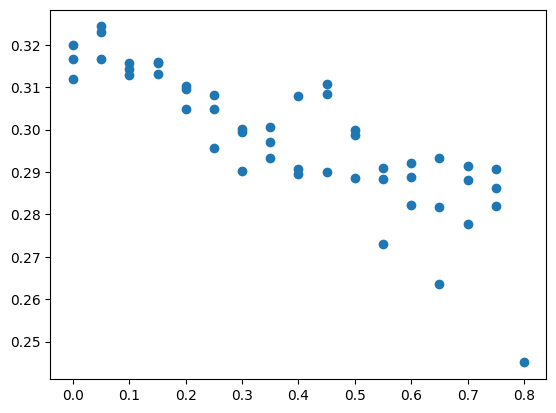

In [8]:
stats = pg_spectra.return_all_split_stats()
plt.scatter(stats['SPECTRA_parameter'], stats['cross_split_overlap'])

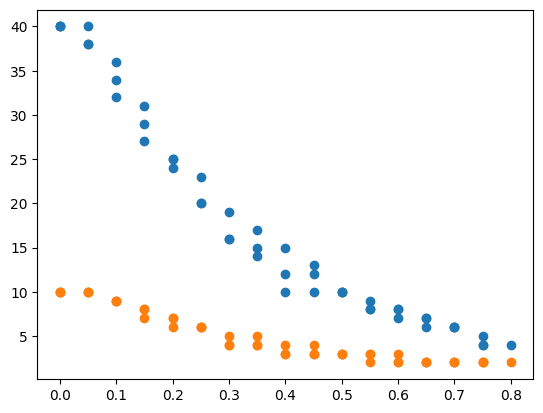

In [9]:
plt.scatter(stats['SPECTRA_parameter'], stats['train_size'])
plt.scatter(stats['SPECTRA_parameter'], stats['test_size']) 